<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

In this notebook, we show how to leverage transfer learning to improve our optimization results. Trasfer learning is a machine learning technique with which we  use the experience obtained solving a determined problem to speed up the solution of a similar (yet different) problem.

In our case, we start by training an agent to find an optimal relaxation with a given Hamiltonian. Then, we can exploit the knowledge gathered by this agent to solve a similar problem, e.g., finding the optimal relaxation with a perturbation of the original Hamiltonian. In order to do so, instead of restarting the learning process from scratch, we take the trained agent from the first problem as starting point to solve the second problem.

In the first tutorial, we used a [`DQNTrainer`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer) to optimize our relaxations. This class provides two ways to do transfer learning. The most straightfoward method is by, simply, training the agents to solve a problem and, then, change the already existing environment and some of the agent hyper-parameters to solve the second problem. The second approach consists on instancing a new [`DQNTrainer`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer) for the second problem with an `agent.model` list containing the pre-trained newtorks. We recommend to use this second approach as it has less risk of having data leakages and we will usually save the trained models in the disk anyway.

With transfer learning, we can obtain advantages in three main aspects: 

* Jumpstart advantage: at the beginning of the training, the rewards obtained with transfer learning are, on average, higher than the ones obtained without introducing prior knowledge. 
* Asymptotic advantage: by the end of the training, on average, more agents reach higher rewards with transfer learning. 
* Convergence advantage: with transfer learning, the convergence is much faster.  

# Transfer learning from scratch

When we do not have any pre-trained models to use for our task at hand, but we want to see how an agent trained in a similar and, maybe, easier problem may be of use for our task, we need to first train these agents. 

For this task, we only need one [`DQNTrainer`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer) whose paramters will be changed between tasks. 

## Problem definition

Here, we will define our two problems characterized by similar Hamiltonians: 
* The initial Hamiltonian `H1`. 
* The second Hamiltonian `H2`, similar to `H1`.

In [ ]:
N = 6
chain = Chain1D(N)

# Hamiltonian 1
b, j = 1., [i%3 for i in range(N)]
H1 = XXHamiltonian(chain, b, j)

# Hamiltonian 2
b, j = 1., [0, 0, 2, 0, 1, 2]
H2 = XXHamiltonian(chain, b, j)

Let's see how they look!

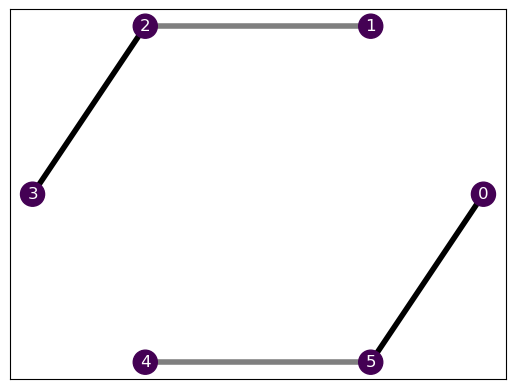

In [ ]:
H1.draw()

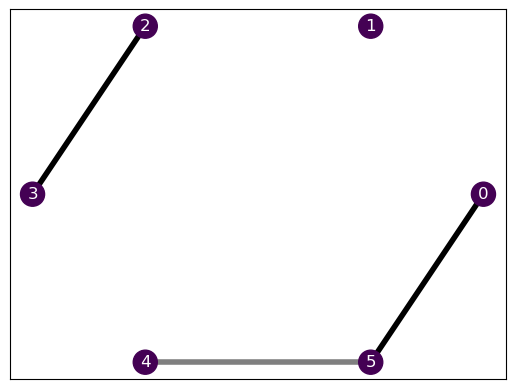

In [ ]:
H2.draw()

They are fairly similar, as they share an entire equal section. If both Hamiltonians had the same ground state, the transfer learning would be completely trivial, provided that the optimal relaxation would be the same. As we show in [our work](https://arxiv.org/abs/2103.03830), we can exploit this to explore the phase diagram of the Hamiltonians, but let's not get ahead of ourselves here! We still need to finish defining our environment. 

In [ ]:
# Solver
solver = SdPEnergySolver()

# Environment
budget = 300
env1 = SdPEnvironment(H1, solver, budget)
env2 = SdPEnvironment(H2, solver, budget)

## The agent

Now that we have our problem instances, we can define our agent to figure out the optimal relaxation for the task.

In [ ]:
# Agent parameters
learning_rate = 2e-3
batch_size = 200
eps_0 = 1.
eps_decay = 0.995
target_update = 5

# Training parameters
episodes = 750
time_steps = 6
opt1 = (-10.9443, 127) 
opt2 = (-10.4721, 83)
best_ref2 = np.array([*opt2, 288]) 
n_agents, jobs = 10, 10 # Parallel trainings and cores

## Solve the first problem

Let us define the [`DQNTrainer`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer) and train an agent to find the optimal solution to the first problem.

In [ ]:
dqn = DQNTrainer(env1, n_agents=n_agents, n_jobs=jobs,
                learning_rate=learning_rate, batch_size=batch_size,
                 eps_decay=eps_decay, eps_0=eps_0, target_update=target_update)

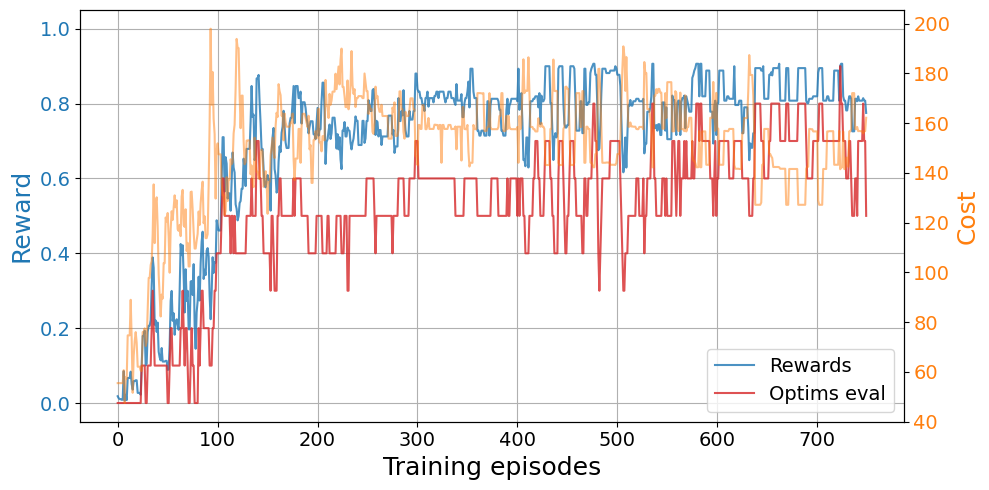

In [ ]:
plot_trainings(results1["training"])

## Change the problem

To properly do transfer learning, we not only have to change the environment, but we also have to reset some of the agent attributes. For example, we need to reset the episodic memory for replay, and we can choose to change the $\varepsilon$ for exploration in the $\varepsilon$-greedy policy. We can use the methods [`DQNTrainer.change_environment`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer.change_environment) and [`DQNTrainer.set_agent_attrs`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer.set_agent_attrs).

In [ ]:
dqn.change_environment(problem=H2) # Change environment hamiltonian
dqn.set_agent_attrs(epsilon=0.8*eps_0, memory=deque(maxlen=10000)) # Reset epsilon and memory

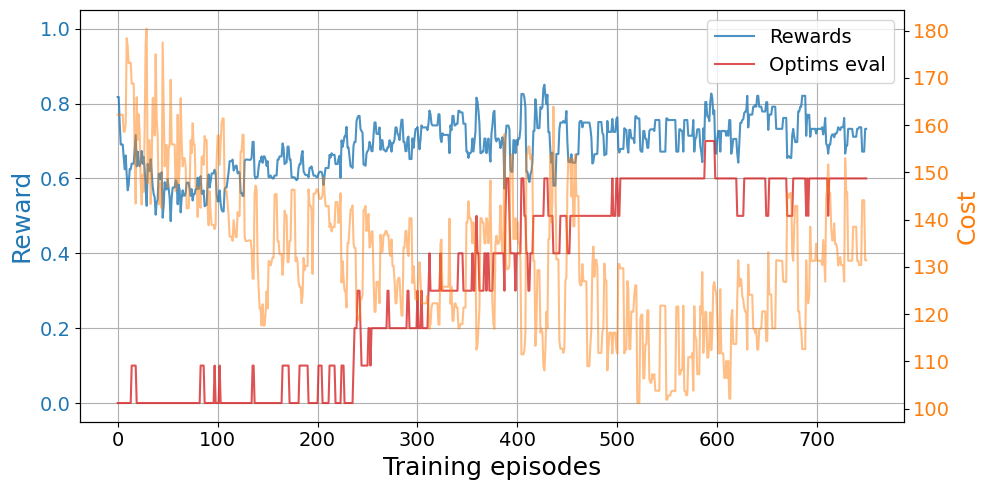

In [ ]:
plot_trainings(tl_results["training"])

## Compare against directly solving the problem

In order to see whether we obtain any kind of advantage with transfer learing, we need to compare the result with respect to a training without any prior knowledge. Therefore, let's create our second problem and solve it from scratch.

In [ ]:
dqn = DQNTrainer(env2, n_agents=n_agents, n_jobs=jobs,
                 learning_rate=learning_rate, batch_size=batch_size,
                 eps_decay=eps_decay, eps_0=eps_0, target_update=target_update)

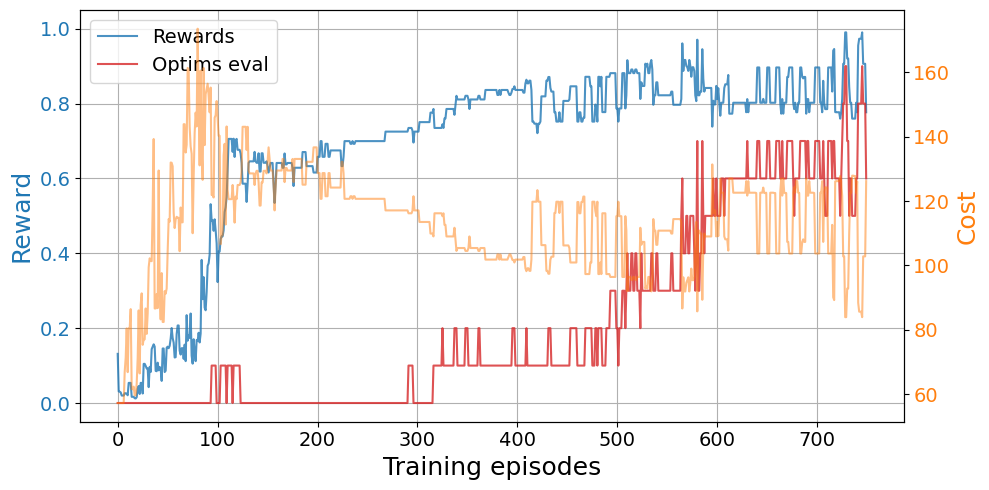

In [ ]:
plot_trainings(base_results['training'])

In this case, we observe a clear jump-start advantage with transfer learning over a cold start. We also observe that some agents find the optimal relaxation sooner in the exploration with transfer learning and the convergence is faster. However, we do not see an asymptotic advantage. 

We can also look at the exploration results of both approaches.

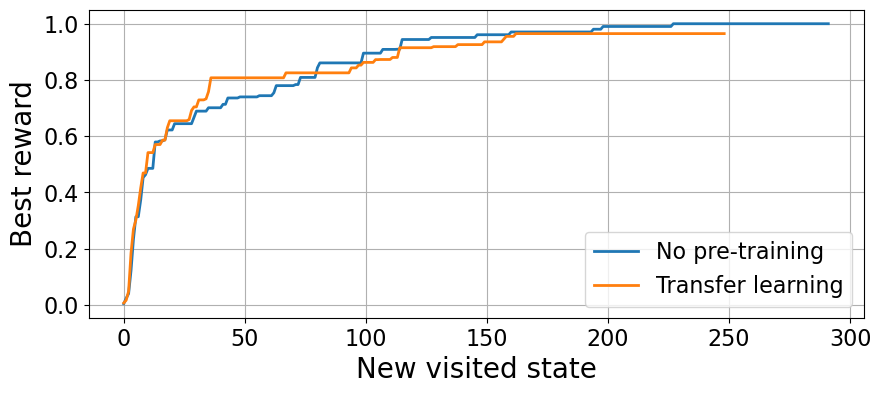

In [ ]:
#| code-fold: true
base_expl = base_results['exploration']
base_rewards = arrange_shape(base_expl['oracle_rewards'])
tl_expl = tl_results["exploration"]
tl_rewards = arrange_shape(tl_expl['oracle_rewards'])

plt.figure(figsize=(10, 4))
plt.plot(np.mean(best_so_far(base_rewards), axis=0), linewidth=2, label="No pre-training")
plt.plot(np.mean(best_so_far(tl_rewards), axis=0), linewidth=2, label="Transfer learning")
plt.grid()
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel("New visited state", fontsize=20)
plt.ylabel("Best reward", fontsize=20);

In this case, we see an early advantage for the transfer learning agents. Unfortunately, in this example we have found that the second transfer learning agent has got stuck heavily and it hinders their statistics. In order to properly compare both approaches, we need to gather more statistics than what we have in this small example :)

::: {.callout-warning}
Just like transfer learning can be beneficial in some cases, it can be completely irrelevant in others. However, it can also be harmful, so be careful!
:::

# Transfer learning from saved models

So far, we have seen a rather naive way of doing transfer learning in which we have all the models loaded at all times and we change the problem only once. A better approach, is to load pre-trained models from the disk. This way, we can train a bunch of models to solve a task and, then, we can load them as many times as we want to solve any other potential tasks. 

## Load the pre-trained models

In this case, we can load the models trained to solve `H1`. We use the function [`load_model`](https://BorjaRequena.github.io/bounce/source/utils.html#load_model) which outpus a dictionary containing both the acutal pytorch model and the mdoel's state_dict. The quantities can be accessed with the keys `'model'` and `'state_dict'`. 

In [ ]:
pre_trained_models = [load_model(H1, budget, ID)['model'] for ID in range(n_agents)]
print(f'We have loaded {len(pre_trained_models)} models')
print(pre_trained_models[0])

We have loaded 10 models
DQN(
  (fc1): Linear(in_features=18, out_features=54, bias=True)
  (fc2): Linear(in_features=54, out_features=38, bias=True)
  (fc3): Linear(in_features=38, out_features=38, bias=True)
  (fc4): Linear(in_features=38, out_features=19, bias=True)
)


## Train the models
Let's now create the [`DQNTrainer`](https://BorjaRequena.github.io/bounce/source/training.html#dqntrainer) to solve the second problem `H2` with the pre-trained models. Whenever we input a collection of models, `n_agents` is automatically adjusted but we still need to choose the amount of parallel threads. 

In [ ]:
dqn_from_models = DQNTrainer(env2, models=pre_trained_models, n_jobs=len(pre_trained_models),
                             eps_0=0.8)

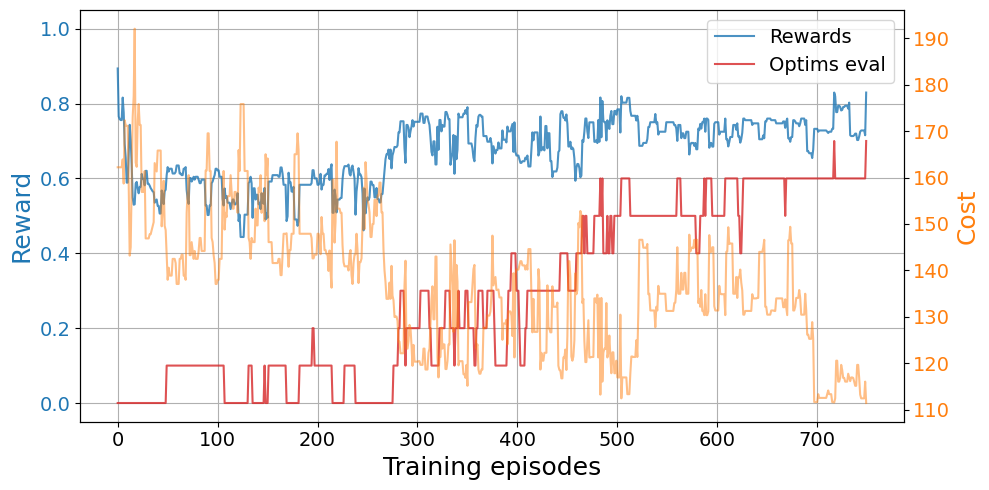

In [ ]:
train_results_models = results_from_models['training'] 
plot_trainings(train_results_models)

# Transfer learning across phases

In the Heisenberg XX model we find two phases with very different ground states. Recall tha the model is characterized by the following Hamiltonian:$$H=\sum_{i} J_{i}(\sigma_{i}^x \sigma_{i+1}^x + \sigma_{i}^y \sigma_{i+1}^y) + \sum_{i}B_{i}\sigma_{i}^z\,,$$ where $\sigma^\alpha$ denote the Pauli matrices with $\alpha=x,y,z$.

Here, we perform transfer learning from deep into one phase of the Hamiltonian to many other points across the phase space. We observe that the transfer learning is trivial along the same phase resulting in a large convergence advantage, provided that the ground state is the same. However, the advantage diminishes sharply across different phases.

## The task
We start by defining the source task `H0` in which we will train our models for the first time. This is deep in the product state phase at $B/J=5$. Then we define the tasks to which we will perform transfer learning `Hs`, which are points across the phase diagram $0\leq B/J \leq 4$. 

In [ ]:
N = 6
chain = Chain1D(N)

# Initial Hamiltonian
B0, J0 = 5, 1
H0 = XXHamiltonian(chain, B0, J0)

# Hamiltonians to transfer
Bs = [np.round(0.1*k, 2) for k in range(20)] + [np.round(2+0.5*k, 2) for k in range(5)]
Hs = [XXHamiltonian(chain, b, J0) for b in Bs]

#Computational budget
budget = 185

# Solver
solver = SdPEnergySolver()

# Environment
env = SdPEnvironment(H0, solver, budget)

## The agent
Now we set our agent parameters and train it on the source task. The saved agents will be used as starting point for the other tasks.

In [ ]:
# Agent parameters
learning_rate = 5e-3
batch_size = 150
eps_decay = 0.996
target_update = 5

episodes = 800
time_steps = 7
n_agents, n_jobs = 60, 15

Remember to only train the source agents once!

In [ ]:
dqn = DQNTrainer(env, n_agents=n_agents, n_jobs=n_jobs,
                 learning_rate=learning_rate, batch_size=batch_size,
                 eps_decay=eps_decay, target_update=target_update)

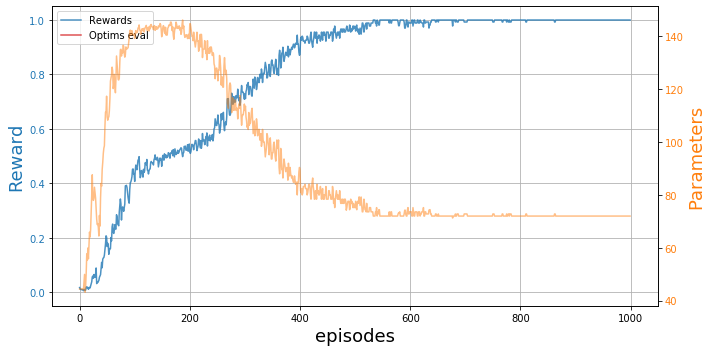

In [ ]:
plot_trainings(results['training'])

We see they have converged nicely!
::: {.callout-note}
These results were obtained with BOUNCE v1, hence the different plot style. However, they are completely reproducible if you have a few hours and a nice GPU :P
:::

## Explore the phase diagram

We can now find the optimal relaxation for all the different Hamiltonians both with transfer learning and starting from scratch. For this case, we will look at the convergence time and see whether we observe any advantage.

In [ ]:
from bounce.utils import convergence_time, get_indiv_times

In [ ]:
TL_evaluation = {B[0]: dict.fromkeys(['tl', 'vanilla', 'time_ratio']) for B in Bs}
for B, H in tqdm(zip(Bs, Hs)):
    env = SdPEnvironment(H, solver, budget)
    pre_trained_models = [load_model(H0, budget, ID)['model']
                          for ID in range(n_agents, 2*n_agents)]
    
    # Solve from scratch
    dqn_cold_start = DQNTrainer(env, n_agents=len(pre_trained_models), n_jobs=n_jobs, 
                                learning_rate=learning_rate, batch_size=batch_size,
                                eps_decay=eps_decay, target_update=target_update)
    results = dqn_cold_start.train(episodes, time_steps=time_steps)
    time = convergence_time(results)
    TL_evaluation[B]['vanilla'] = deepcopy(results['training'])
    del dqn_cold_start; del results
    
    # Solve with transfer learning
    dqn_from_models = DQNTrainer(env, models=pre_trained_models, n_jobs=n_jobs, 
                                 learning_rate=learning_rate, batch_size=batch_size,
                                 eps_0=eps_0, eps_decay=eps_decay, target_update=target_update)
    results_tl = dqn_from_models.train(episodes, time_steps=time_steps, save=False)
    time_tl = convergence_time(results_tl)
    TL_evaluation[B]['tl'] = deepcopy(results_tl['training'])
    del dqn_from_models; del results_tl
    
    time = convergence_time(TL_evaluation[B]['vanilla'])
    TL_evaluation[B]['time_ratio'] = time_tl/time

Now we can plot the ratio between the convergence time with transfer learning $t_{TL}$, and the convergence time starting from scratch $t_0$.

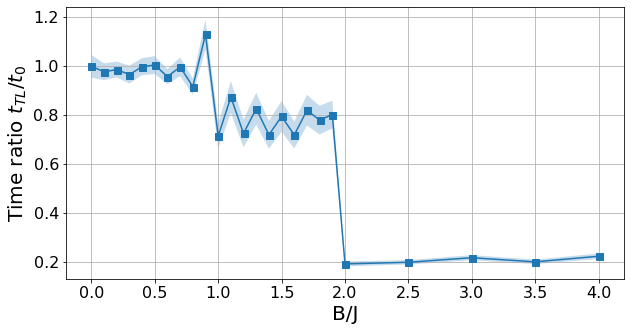

In [ ]:
#| code-fold: true
Bs, time_ratios, time_errs = get_indiv_times(TL_evaluation)

plt.figure(figsize=(10, 5))
plt.fill_between(Bs, time_ratios-time_errs, time_ratios+time_errs, alpha=0.25)
plt.plot(Bs, time_ratios, 's-', ms=7)
plt.grid()
plt.tick_params(labelsize=16)
plt.xlabel("B/J", fontsize=20)
plt.ylabel(r"Time ratio $t_{TL}/t_0$", fontsize=20);

If $t_{TL}/t_0 < 1$, it means that the transfer learning provided an advantage. In this case, we see that there is a huge advantage for the product state phase, where we have done the pretraining. This is because the ground state is the same for the whole phase $B/J\geq 2$ and, thus, so is the optimal relaxation. 

As we cross the phase transition at $B/J=2$, we observe a sharp drop in convergence time. As we go deeper in the opposite phase, we observe that $t_{TL}/t_0\to1$, meaning that the convergence advantage banishes. For further details, see [our work](https://arxiv.org/abs/2103.03830).